# Analysis of OM2-$0.25^o$ with high vertical resolution

Previous analysis of OM2-$0.1^o$ have shown that a vertical resolution of a minimum 1 m in the to is requried to properly represent the surface Ekman Transports, and the DSW formation in the Antarctic shelf.

To test if these results are relevant for climate models ( which have resolutions of ~ $0.25^o$ we ran 2 additionale xperiments with the 1mtop and 5mtop grid with ACCESS-OM2-025. This notebook analyses if we see the same results in coarse resolution experiments. The results will focus in 3 main aspects.

- Part 1: Surface Ekman transports in the first month of each simulation (Wind effect, 1mtop vs 5mtop)
- Part 2: Shelf salinity changes with resolution
- Part 3: DSW formation ( or at leas dense water formation) on the shelf in the two different model vertical resolutions
- Part 4; DSW overflow  ( or at leas dense water overflow) across the slope in the two different model vertical resolutions

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean

from dask.distributed import Client

In [2]:
client = Client(n_workers=28, memory_limit='250gb')

In [3]:
OM025_session = cc.database.create_session('/home/156/wf4500/databases/access/OM2_25_DSW.db')
cosima_session = cc.database.create_session()

In [4]:
#defining experiment names
exp_025_1m = '025deg_jra55_ryf'
exp_025_5m = '025deg_jra55_ryf_5mtop'
exp_01_1m = '01deg_jra55v13_ryf9091_21mbath'
exp_01_5m = '01deg_jra55v13_ryf9091_21mbath_5mtop'
lat_range = slice(-82, -59)

## Part 1 - Ekman transport and salinity response

In [5]:
#importing first month salinity field in MOM5and MOM6
large_lat_slice=slice(-90,-50)
depth_slice_20m = slice(0,50)
depth_slice_5m = slice(0,50)


#MOM5_01 first month Salinity ############################
S_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'salt', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yt_ocean=large_lat_slice).isel(time=0).sel(st_ocean=depth_slice_5m)

dzt_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dzt', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yt_ocean=large_lat_slice).isel(time=0).sel(st_ocean=depth_slice_5m)


S_MOM5_1m_20m_mean = S_MOM5_1m.weighted(dzt_MOM5_1m.fillna(0)).mean('st_ocean').load()

#MOM5_01 first month Salinity ############################
S_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'salt', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yt_ocean=large_lat_slice).isel(time=0).sel(st_ocean=depth_slice_5m)

dzt_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'dzt', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yt_ocean=large_lat_slice).isel(time=0).sel(st_ocean=depth_slice_5m)


S_MOM5_025_1m_20m_mean = S_MOM5_025_1m.weighted(dzt_MOM5_025_1m.fillna(0)).mean('st_ocean').load()

In [6]:
#Full depth mean salinity

#MOM5_01 first month Salinity ############################
S_MOM5_1m_fulldepth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/'+\
                                      '01deg_jra55v13_ryf9091_21mbath/output000/ocean/ocean.nc').\
salt.isel(time=0).sel(yt_ocean=slice(-90,-55.009))

S_MOM5_5m_fulldepth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/'+\
                                      '01deg_jra55v13_ryf9091_21mbath_5mtop/output000/ocean/ocean.nc').\
salt.isel(time=0).sel(yt_ocean=slice(-90,-55.009))

#MOM5_025 first month Salinity ############################
S_MOM5_1m_025_fulldepth = cc.querying.getvar(exp_025_1m, 'salt', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.isel(time=0).sel(yt_ocean=slice(-90,-55.009)).load()

S_MOM5_5m_025_fulldepth = cc.querying.getvar(exp_025_5m, 'salt', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.isel(time=0).sel(yt_ocean=slice(-90,-55.009)).load()



In [7]:
%%time
lat_slice=slice(-90,-55)
#MOM5 first month U, V and umo, vmo ############################
## some grid data is required, a little complicated because these variables don't behave well with some 
dyt = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dyt',cosima_session, n=1, ncfile = 'ocean_grid.nc')
dxt = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'dxt',cosima_session, n=1, ncfile = 'ocean_grid.nc')

# select latitude range:
dxt = dxt.isel(yt_ocean=slice(0,511)).load()
dyt = dyt.isel(yt_ocean=slice(0,511)).load()

####### MOM5_01 ############
### 1m ###
u_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'u', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
v_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'v', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()

umo_MOM5_1m = ((cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'uhrho_et', cosima_session, n=1,\
                                 ncfile='rregionocean%',chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035) ).load() #m2/s
umo_MOM5_1m['yt_ocean']= dyt.yt_ocean
umo_MOM5_1m = umo_MOM5_1m*dyt #m3/s


vmo_MOM5_1m = ( cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'vhrho_nt', cosima_session, n=1,\
                                 ncfile='rregionocean%',chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
vmo_MOM5_1m['yt_ocean']= dxt.yt_ocean
vmo_MOM5_1m = vmo_MOM5_1m*dxt #m3/s


𝜏x_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'tau_x', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()
𝜏y_MOM5_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'tau_y', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()


### 5m ###
u_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'u', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
v_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'v', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()

umo_MOM5_5m = (cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'uhrho_et', cosima_session, n=1,\
                                 ncfile='rregionocean%',chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
umo_MOM5_5m['yt_ocean']= dyt.yt_ocean
umo_MOM5_5m = umo_MOM5_5m*dyt #m3/s


vmo_MOM5_5m = (cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'vhrho_nt', cosima_session, n=1,\
                                 ncfile='rregionocean%',chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub01':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m3/s
vmo_MOM5_5m['yt_ocean']= dxt.yt_ocean
vmo_MOM5_5m = vmo_MOM5_5m*dxt #m3/s


𝜏x_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'tau_x', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()
𝜏y_MOM5_5m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath_5mtop', 'tau_y', cosima_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()


CPU times: user 8min 9s, sys: 35.7 s, total: 8min 45s
Wall time: 9min 8s


In [8]:
%%time

############### for MOM5_01 ##############
#MOM5 first month U, V and umo, vmo ############################
## some grid data is required, a little complicated because these variables don't behave well with some 
dyt_025 = cc.querying.getvar(exp_025_1m, 'dyt',OM025_session, n=1, ncfile = 'ocean_grid.nc')
dxt_025 = cc.querying.getvar(exp_025_1m, 'dxt',OM025_session, n=1, ncfile = 'ocean_grid.nc')

# select latitude range:
dxt_025 = dxt_025.sel(yt_ocean=slice(dxt.yt_ocean.min(),dxt.yt_ocean.max()+0.1)).load()
dyt_025 = dyt_025.sel(yt_ocean=slice(dxt.yt_ocean.min(),dxt.yt_ocean.max()+0.1)).load()

####### MOM5_01 ############
### 1m ###
u_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'u', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
v_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'v', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()

umo_MOM5_025_1m = ((cc.querying.getvar(exp_025_1m, 'uhrho_et', OM025_session, n=1,\
                                 chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035) ).load() #m2/s
umo_MOM5_025_1m['yt_ocean']= dyt_025.yt_ocean
umo_MOM5_025_1m = umo_MOM5_025_1m*dyt_025 #m3/s


vmo_MOM5_025_1m = ( cc.querying.getvar(exp_025_1m, 'vhrho_nt', OM025_session, n=1,\
                                 chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
vmo_MOM5_025_1m['yt_ocean']= dxt_025.yt_ocean
vmo_MOM5_025_1m = vmo_MOM5_025_1m*dxt_025 #m3/s


𝜏x_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'tau_x', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()
𝜏y_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'tau_y', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()


### 5m ###
u_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'u', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()
v_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'v', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).sel(st_ocean=depth_slice_20m).load()

umo_MOM5_025_5m = (cc.querying.getvar(exp_025_5m, 'uhrho_et', OM025_session, n=1,\
                                 chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
umo_MOM5_025_5m['yt_ocean']= dyt_025.yt_ocean
umo_MOM5_025_5m = umo_MOM5_025_5m*dyt_025 #m3/s


vmo_MOM5_025_5m = (cc.querying.getvar(exp_025_5m, 'vhrho_nt', OM025_session, n=1,\
                                 chunks = {})\
.isel(time=slice(0,31)).sel(st_ocean=depth_slice_20m).\
rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m3/s
vmo_MOM5_025_5m['yt_ocean']= dxt_025.yt_ocean
vmo_MOM5_025_5m = vmo_MOM5_025_5m*dxt_025 #m3/s


𝜏x_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'tau_x', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()
𝜏y_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'tau_y', OM025_session, n=1,frequency='1 monthly',chunks = {})\
.sel(yu_ocean=lat_slice).isel(time=0).load()

CPU times: user 2min 35s, sys: 11.2 s, total: 2min 46s
Wall time: 2min 54s


In [9]:
# # 2 months mean option
# %%time

# ############### for MOM5_01 ##############
# #MOM5 first month U, V and umo, vmo ############################
# ## some grid data is required, a little complicated because these variables don't behave well with some 
# dyt_025 = cc.querying.getvar(exp_025_1m, 'dyt',OM025_session, n=1, ncfile = 'ocean_grid.nc')
# dxt_025 = cc.querying.getvar(exp_025_1m, 'dxt',OM025_session, n=1, ncfile = 'ocean_grid.nc')

# # select latitude range:
# dxt_025 = dxt_025.sel(yt_ocean=slice(dxt.yt_ocean.min(),dxt.yt_ocean.max()+0.1)).load()
# dyt_025 = dyt_025.sel(yt_ocean=slice(dxt.yt_ocean.min(),dxt.yt_ocean.max()+0.1)).load()

# ####### MOM5_01 ############
# ### 1m ###
# u_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'u', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').sel(st_ocean=depth_slice_20m).load()
# v_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'v', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').sel(st_ocean=depth_slice_20m).load()

# umo_MOM5_025_1m = ((cc.querying.getvar(exp_025_1m, 'uhrho_et', OM025_session, n=2,\
#                                  chunks = {})\
# .isel(time=slice(0,60)).sel(st_ocean=depth_slice_20m).\
# rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035) ).load() #m2/s
# umo_MOM5_025_1m['yt_ocean']= dyt_025.yt_ocean
# umo_MOM5_025_1m = umo_MOM5_025_1m*dyt_025 #m3/s


# vmo_MOM5_025_1m = ( cc.querying.getvar(exp_025_1m, 'vhrho_nt', OM025_session, n=2,\
#                                  chunks = {})\
# .isel(time=slice(0,60)).sel(st_ocean=depth_slice_20m).\
# rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
# vmo_MOM5_025_1m['yt_ocean']= dxt_025.yt_ocean
# vmo_MOM5_025_1m = vmo_MOM5_025_1m*dxt_025 #m3/s


# 𝜏x_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'tau_x', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').load()
# 𝜏y_MOM5_025_1m = cc.querying.getvar(exp_025_1m, 'tau_y', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').load()


# ### 5m ###
# u_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'u', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').sel(st_ocean=depth_slice_20m).load()
# v_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'v', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').sel(st_ocean=depth_slice_20m).load()

# umo_MOM5_025_5m = (cc.querying.getvar(exp_025_5m, 'uhrho_et', OM025_session, n=21,\
#                                  chunks = {})\
# .isel(time=slice(0,60)).sel(st_ocean=depth_slice_20m).\
# rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m2/s
# umo_MOM5_025_5m['yt_ocean']= dyt_025.yt_ocean
# umo_MOM5_025_5m = umo_MOM5_025_5m*dyt_025 #m3/s


# vmo_MOM5_025_5m = (cc.querying.getvar(exp_025_5m, 'vhrho_nt', OM025_session, n=2,\
#                                  chunks = {})\
# .isel(time=slice(0,60)).sel(st_ocean=depth_slice_20m).\
# rename({'yt_ocean_sub02':'yt_ocean','xt_ocean_sub01':'xt_ocean'}).mean('time')/1035).load() #m3/s
# vmo_MOM5_025_5m['yt_ocean']= dxt_025.yt_ocean
# vmo_MOM5_025_5m = vmo_MOM5_025_5m*dxt_025 #m3/s


# 𝜏x_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'tau_x', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').load()
# 𝜏y_MOM5_025_5m = cc.querying.getvar(exp_025_5m, 'tau_y', OM025_session, n=2,frequency='1 monthly',chunks = {})\
# .sel(yu_ocean=lat_slice).mean('time').load()

extracting transports on MOM5_01

In [10]:
#extrating the values 
outfile = '/g/data/g40/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','yt_ocean',cosima_session,n=1)
yt_ocean = yt_ocean.isel(yt_ocean=slice(0,510))
yu_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','yu_ocean',cosima_session,n=1)
yu_ocean1 = yu_ocean.isel(yu_ocean=slice(0,511))
yu_ocean = yu_ocean.isel(yu_ocean=slice(0,510))
xt_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','xt_ocean',cosima_session,n=1)
xu_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath','xu_ocean',cosima_session,n=1)


mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yt_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

In [11]:
##### getting the transports across isobath

####  MOM5_1M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (umo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (vmo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)
vol_trans_across_contour_1m = xr.concat((x_transport_1m, y_transport_1m), dim = 'contour_index').sum('contour_index')
vol_trans_across_contour_1m_CI = xr.concat((x_transport_1m, y_transport_1m), dim = 'contour_index')


# ####  MOM5_5M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (umo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (vmo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)

vol_trans_across_contour_5m = xr.concat((x_transport_5m, y_transport_5m), dim = 'contour_index').sum('contour_index')


In [12]:


####  MOM5_1M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (umo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (vmo_MOM5_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)


U_transport_1m = x_transport_1m.sum('contour_index')
V_transport_1m = y_transport_1m.sum('contour_index')
U_transport_1m_NS = x_transport_1m
V_transport_1m_NS = y_transport_1m


# ####  MOM5_5M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_5m = (umo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_5m = x_transport_5m.where(mask_x_numbered_1d>0, drop = True)
y_transport_5m = (vmo_MOM5_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_5m = y_transport_5m.where(mask_y_numbered_1d>0, drop = True)

U_transport_5m = x_transport_5m.sum('contour_index')
V_transport_5m = y_transport_5m.sum('contour_index')
U_transport_5m_NS = x_transport_5m
V_transport_5m_NS = y_transport_5m



In [13]:
#Getting the area along the contour in MOM5
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091', 'area_t', cosima_session, n=1) # needed for the plots I'll provide.
area_t.load()
x_area = (area_t.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_area = x_area.where(mask_x_numbered_1d>0, drop = True)
y_area = (area_t.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_area = y_area.where(mask_y_numbered_1d>0, drop = True)
MOM5_area_contour = xr.concat((x_area, y_area), dim = 'contour_index') #non-ordenated

In [14]:
#mean salinity along the contour - MOM5_1m
x_S_1m = (S_MOM5_1m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_S_1m = x_S_1m.where(mask_x_numbered_1d>0, drop = True)
y_S_1m = (S_MOM5_1m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_S_1m = y_S_1m.where(mask_y_numbered_1d>0, drop = True)
S_1m_MOM5_contour = xr.concat((x_S_1m, y_S_1m), dim = 'contour_index') #non-ordenated
S_1m_MOM5_contourmean=S_1m_MOM5_contour.weighted(MOM5_area_contour.fillna(0)).mean('contour_index')
    
#mean salinity along the contour - MOM5_5m
x_S_5m = (S_MOM5_5m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_S_5m = x_S_5m.where(mask_x_numbered_1d>0, drop = True)
y_S_5m = (S_MOM5_5m_fulldepth.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_S_5m = y_S_5m.where(mask_y_numbered_1d>0, drop = True)
S_5m_MOM5_contour = xr.concat((x_S_5m, y_S_5m), dim = 'contour_index') #non-ordenated
S_5m_MOM5_contourmean=S_5m_MOM5_contour.weighted(MOM5_area_contour.fillna(0)).mean('contour_index')


In [15]:
def shelf_mask_isobath_MOM5_01(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [16]:
S_MOM5_1m_fulldepth_masked, shelf_mask = shelf_mask_isobath_MOM5_01(S_MOM5_1m_fulldepth)
areat_shelf, shelf_mask = shelf_mask_isobath_MOM5_01(area_t)

In [17]:
#on the shelf
S_MOM5_1m_shelfmean_day0 = S_MOM5_1m_fulldepth.where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_shelfmean_day0 = S_MOM5_5m_fulldepth.where(shelf_mask==1).weighted(areat_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()

## We will impose a nirthward limit of 60S into the offshore mean salinity
offshore_lat_limit=slice(-90,-66)
#off the shelf
S_MOM5_1m_offshoremean_day0 = S_MOM5_1m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(shelf_mask==0).weighted(area_t.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_offshoremean_day0 = S_MOM5_5m_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(shelf_mask==0).weighted(area_t.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()


***Now for OM2_025***

In [18]:
#extrating the values 
outfile = '/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/OM2_025_1000m_isobath_contour.npz'
data = np.load(outfile)
mask_y_transport_025 = data['mask_y_transport']
mask_x_transport_025 = data['mask_x_transport']
mask_y_transport_numbered_025 = data['mask_y_transport_numbered']
mask_x_transport_numbered_025 = data['mask_x_transport_numbered']

lat_range_025 = slice(-82, -59)
yt_ocean_025 = cc.querying.getvar(exp_025_1m,'yt_ocean',OM025_session,n=1)
yt_ocean_025 = yt_ocean_025.sel(yt_ocean=lat_range_025)
yu_ocean_025 = cc.querying.getvar(exp_025_1m,'yu_ocean',OM025_session,n=1)
yu_ocean_025 = yu_ocean_025.isel(yu_ocean=lat_range_025)
#yu_ocean_025 = yu_ocean_025.isel(yu_ocean=slice(0,510))
xt_ocean_025 = cc.querying.getvar(exp_025_1m,'xt_ocean',OM025_session,n=1)
xu_ocean_025 = cc.querying.getvar(exp_025_1m,'xu_ocean',OM025_session,n=1)


mask_x_transport_025 = xr.DataArray(mask_x_transport_025, coords = [yt_ocean_025, xt_ocean_025], dims=['y_ocean', 'x_ocean'])
mask_y_transport_025 = xr.DataArray(mask_y_transport_025, coords = [yt_ocean_025, xt_ocean_025], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered_025 = xr.DataArray(mask_x_transport_numbered_025, coords = [yt_ocean_025, xt_ocean_025], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered_025 = xr.DataArray(mask_y_transport_numbered_025, coords = [yt_ocean_025, xt_ocean_025], dims=['y_ocean', 'x_ocean'])

mask_x_numbered_1d_025 = mask_x_transport_numbered_025.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d_025 = mask_x_numbered_1d_025.where(mask_x_numbered_1d_025 > 0, drop = True)
mask_y_numbered_1d_025 = mask_y_transport_numbered_025.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d_025 = mask_y_numbered_1d_025.where(mask_y_numbered_1d_025 > 0, drop = True)
contour_ordering_025  = xr.concat((mask_x_numbered_1d_025 ,mask_y_numbered_1d_025 ), dim = 'contour_index')
contour_ordering_025 = contour_ordering_025.sortby(contour_ordering_025)
contour_index_array_025 = np.arange(1,len(contour_ordering_025)+1)

In [19]:
vmo_MOM5_025_1m = vmo_MOM5_025_1m.isel(yt_ocean=slice(0,204))
umo_MOM5_025_1m = umo_MOM5_025_1m.isel(yt_ocean=slice(0,204))
vmo_MOM5_025_5m = vmo_MOM5_025_5m.isel(yt_ocean=slice(0,204))
umo_MOM5_025_5m = umo_MOM5_025_5m.isel(yt_ocean=slice(0,204))

In [20]:
umo_MOM5_025_1m['xt_ocean'] = mask_x_transport_025.x_ocean.values
vmo_MOM5_025_1m['xt_ocean'] = mask_y_transport_025.x_ocean.values
#vmo_MOM5_025_1m = vmo_MOM5_025_1m.isel(yt_ocean = slice(0,204))
vmo_MOM5_025_1m['yt_ocean'] = mask_y_transport_025.y_ocean.values

umo_MOM5_025_5m['xt_ocean'] = mask_x_transport_025.x_ocean.values
vmo_MOM5_025_5m['xt_ocean'] = mask_y_transport_025.x_ocean.values
#vmo_MOM5_025_5m = vmo_MOM5_025_5m.isel(yt_ocean = slice(0,204))
vmo_MOM5_025_5m['yt_ocean'] = mask_y_transport_025.y_ocean.values


(50.0, 0.0)

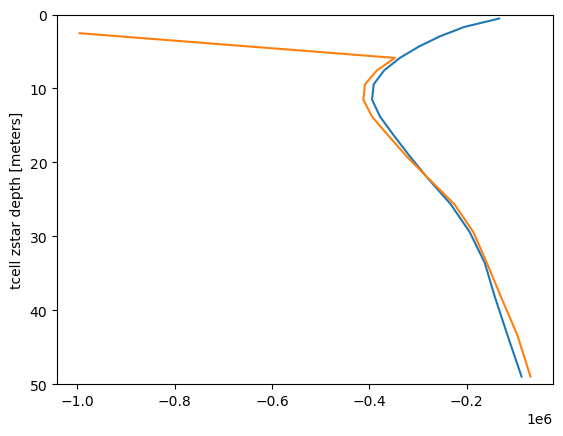

In [21]:
##### getting the transports across isobath

####  MOM5_1M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_025_1m = (umo_MOM5_025_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport_025)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_025_1m = x_transport_025_1m.where(mask_x_numbered_1d_025>0, drop = True)
y_transport_025_1m = (vmo_MOM5_025_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport_025)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_025_1m = y_transport_025_1m.where(mask_y_numbered_1d_025>0, drop = True)
vol_trans_across_contour_1m_025 = xr.concat((x_transport_025_1m, y_transport_025_1m), dim = 'contour_index').sum('contour_index')



# # ####  MOM5_5M ##############
# # stack transports into 1d and drop any points not on contour:
x_transport_025_5m = (umo_MOM5_025_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_x_transport_025)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_025_5m = x_transport_025_5m.where(mask_x_numbered_1d_025>0, drop = True)
y_transport_025_5m = (vmo_MOM5_025_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})*mask_y_transport_025)\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_025_5m = y_transport_025_5m.where(mask_y_numbered_1d_025>0, drop = True)

vol_trans_across_contour_5m_025 = xr.concat((x_transport_025_5m, y_transport_025_5m), dim = 'contour_index').sum('contour_index')
vol_trans_across_contour_1m_025.plot(y='st_ocean')
vol_trans_across_contour_5m_025.plot(y='st_ocean')
plt.ylim(50,0)

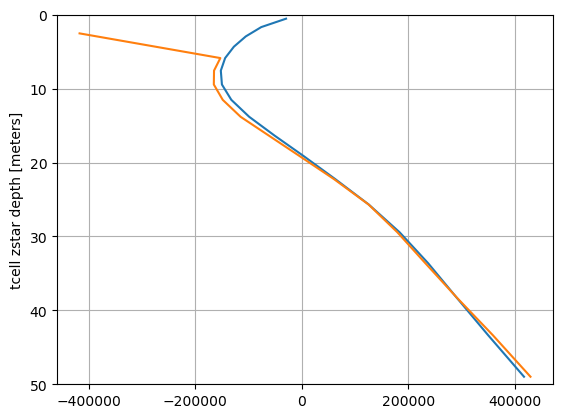

In [22]:


####  MOM5_1M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_025_1m = (umo_MOM5_025_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_025_1m = x_transport_025_1m.where(mask_x_numbered_1d_025>0, drop = True)
y_transport_025_1m = (vmo_MOM5_025_1m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_025_1m = y_transport_025_1m.where(mask_y_numbered_1d_025>0, drop = True)


U_transport_1m_025 = x_transport_025_1m.sum('contour_index')
V_transport_1m_025 = y_transport_025_1m.sum('contour_index')
U_transport_1m_025_NS = x_transport_025_1m
V_transport_1m_025_NS = y_transport_025_1m


# # ####  MOM5_5M ##############
# stack transports into 1d and drop any points not on contour:
x_transport_025_5m = (umo_MOM5_025_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_025_5m = x_transport_025_5m.where(mask_x_numbered_1d_025>0, drop = True)
y_transport_025_5m = (vmo_MOM5_025_5m.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_025_5m = y_transport_025_5m.where(mask_y_numbered_1d_025>0, drop = True)

U_transport_5m_025 = x_transport_025_5m.sum('contour_index')
V_transport_5m_025 = y_transport_025_5m.sum('contour_index')
U_transport_5m_025_NS = x_transport_025_5m
V_transport_5m_025_NS = y_transport_025_5m

V_transport_1m_025.plot(y='st_ocean')
V_transport_5m_025.plot(y='st_ocean')
plt.ylim(50,0)
plt.grid()

In [23]:
#Getting the area along the contour in MOM5
area_t_025 = cc.querying.getvar(exp_025_5m, 'area_t', OM025_session, n=1).rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'}).isel(y_ocean=slice(0,204)) # needed for the plots I'll provide.
area_t_025.load()
area_t_025['x_ocean'] = mask_x_transport_025.x_ocean
area_t_025['y_ocean'] = mask_x_transport_025.y_ocean
x_area_025 = (area_t_025).stack(contour_index = ['y_ocean', 'x_ocean'])
x_area_025 = x_area_025.where(mask_x_numbered_1d_025>0, drop = True)
area_t_025['x_ocean'] = mask_y_transport_025.x_ocean
area_t_025['y_ocean'] = mask_y_transport_025.y_ocean
y_area_025 = (area_t_025).stack(contour_index = ['y_ocean', 'x_ocean'])
y_area_025 = y_area_025.where(mask_y_numbered_1d_025>0, drop = True)
MOM5_area_contour_025 = xr.concat((x_area_025, y_area_025), dim = 'contour_index') #non-ordenated
area_t_025 = cc.querying.getvar(exp_025_5m, 'area_t', OM025_session, n=1) # needed for the plots I'll provide.
area_t_025.load()

<xarray.DataArray 'area_t' (yt_ocean: 1080, xt_ocean: 1440)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/scratch/oz91/wf4500/ACCESSS_OM2_025/025_ryf_5mtop/wf450...

In [24]:
data_nc = xr.open_dataset('/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/OM2_025_1000m_isobath_contour.nc')
OM025_shelf_mask = data_nc.shelf_mask.rename({'ym_ocean':'yt_ocean','xm_ocean':'xt_ocean'})

In [25]:
area_t_025_shelf = area_t_025*OM025_shelf_mask

In [26]:
#on the shelf
S_MOM5_1m_025_shelfmean_day0 = S_MOM5_1m_025_fulldepth.where(OM025_shelf_mask==1).weighted(area_t_025_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_025_shelfmean_day0 = S_MOM5_5m_025_fulldepth.where(OM025_shelf_mask==1).weighted(area_t_025_shelf.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()

## We will impose a nirthward limit of 60S into the offshore mean salinity
offshore_lat_limit=slice(-90,-66)
#off the shelf
S_MOM5_1m_025_offshoremean_day0 = S_MOM5_1m_025_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(OM025_shelf_mask.fillna(0)==0).weighted(area_t_025.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()
S_MOM5_5m_025_offshoremean_day0 = S_MOM5_5m_025_fulldepth.sel(yt_ocean=offshore_lat_limit)\
.where(OM025_shelf_mask.fillna(0)==0).weighted(area_t_025.fillna(0))\
.mean(('xt_ocean','yt_ocean')).load()

In [27]:
################ MOM5 1m  𝜏x,𝜏y #######################################
#interpolating into the t grid)
𝜏x_MOM5_1m_tg = 𝜏x_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})
𝜏y_MOM5_1m_tg = 𝜏y_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})

#getting the values along the grid
# stack transports into 1d and drop any points not on contour:
x_transport_1m = (𝜏x_MOM5_1m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m = x_transport_1m.where(mask_x_numbered_1d>0, drop = True)
y_transport_1m = (𝜏y_MOM5_1m_tg.rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'}))\
.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m = y_transport_1m.where(mask_y_numbered_1d>0, drop = True)

MOM5_𝜏xmean_1m = (x_transport_1m *x_area).sum('contour_index')/(x_area.sum('contour_index'))
MOM5_𝜏ymean_1m = (y_transport_1m *y_area).sum('contour_index')/(y_area.sum('contour_index'))



  𝜏x_MOM5_1m_tg = 𝜏x_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})

  𝜏y_MOM5_1m_tg = 𝜏y_MOM5_1m.interp(xu_ocean=umo_MOM5_1m.xt_ocean,yu_ocean=umo_MOM5_1m.yt_ocean).drop({'xu_ocean','yu_ocean'})



In [28]:
################ MOM5 1m  𝜏x,𝜏y #######################################
#interpolating into the t grid)
𝜏x_MOM5_025_1m_tg = 𝜏x_MOM5_025_1m.interp(xu_ocean=umo_MOM5_025_1m.xt_ocean,yu_ocean=umo_MOM5_025_1m.yt_ocean).drop({'xu_ocean','yu_ocean'}).rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})
𝜏y_MOM5_025_1m_tg = 𝜏y_MOM5_025_1m.interp(xu_ocean=umo_MOM5_025_1m.xt_ocean,yu_ocean=umo_MOM5_025_1m.yt_ocean).drop({'xu_ocean','yu_ocean'}).isel(yt_ocean=slice(0,204)).rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})
𝜏y_MOM5_025_1m_tg['x_ocean'] = mask_y_transport_025.x_ocean.values
𝜏y_MOM5_025_1m_tg['y_ocean'] = mask_y_transport_025.y_ocean.values
#getting the values along the grid
# stack transports into 1d and drop any points not on contour:
x_transport_1m_025 = (𝜏x_MOM5_025_1m_tg).stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1m_025 = x_transport_1m_025.where(mask_x_numbered_1d_025>0, drop = True)
y_transport_1m_025 = (𝜏y_MOM5_025_1m_tg).stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1m_025 = y_transport_1m_025.where(mask_y_numbered_1d_025>0, drop = True)

MOM5_𝜏xmean_1m_025 = (x_transport_1m_025 *x_area_025).sum('contour_index')/(x_area_025.sum('contour_index'))
MOM5_𝜏ymean_1m_025 = (y_transport_1m_025*y_area_025).sum('contour_index')/(y_area_025.sum('contour_index'))

  𝜏x_MOM5_025_1m_tg = 𝜏x_MOM5_025_1m.interp(xu_ocean=umo_MOM5_025_1m.xt_ocean,yu_ocean=umo_MOM5_025_1m.yt_ocean).drop({'xu_ocean','yu_ocean'}).rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})

  𝜏y_MOM5_025_1m_tg = 𝜏y_MOM5_025_1m.interp(xu_ocean=umo_MOM5_025_1m.xt_ocean,yu_ocean=umo_MOM5_025_1m.yt_ocean).drop({'xu_ocean','yu_ocean'}).isel(yt_ocean=slice(0,204)).rename({'xt_ocean':'x_ocean','yt_ocean':'y_ocean'})



In [29]:
sw_ocean_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'sw_ocean', cosima_session, n=1,chunks = {}).\
sel(sw_ocean=slice(0,20))

In [30]:
from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.path as mpath
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ht = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', cosima_session, n=1).sel(yt_ocean=lat_slice)
ht_50S = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'ht', cosima_session, n=1).sel(yt_ocean=slice(-90,-50)).load()
land_mask = (ht*0).fillna(1)

In [31]:
import cmocean.cm as cmo

It's figure time!

In [166]:
from functools import partial

# figure = plt.figure(num = 1, figsize = (12, 16))
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.3,
#                     hspace=0.5)




# #maps WIth Jan Salinity in MOM5 ##########################################################################
# proj = ccrs.PlateCarree()
# ax325 = plt.subplot(3,2,1, projection=ccrs.SouthPolarStereo())
# ax325.set_extent([-180, 180, -90, -55], proj)
# ax325.set_boundary(circle, transform=ax325.transAxes)

# gl = ax325.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)



# ax325.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'snow', linewidth=.7,
#             transform=proj,)




# p325 = ax325.pcolormesh(S_MOM5_1m_20m_mean.xt_ocean, S_MOM5_1m_20m_mean.yt_ocean,
#                    S_MOM5_1m_20m_mean,\
#                         vmin=33.7,vmax=34.2,cmap = cmo.haline
#                    , transform=proj,
#                    rasterized=True, zorder=1)
# pos = ax325.get_position()


# cax_0T = plt.axes([pos.xmin+0.01, pos.ymin-0.035,
#                 .9*(pos.xmax-pos.xmin), 0.015])

# cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax_0T, extend='both')
# cb325.ax.tick_params(labelsize=12)
# cb325.ax.set_xlabel(r'$PSU$',fontsize=13)


# cb325.ax.tick_params(labelsize=12)
# cb325.ax.set_xlabel(r'[$PSU$]',fontsize=13)






# ax325.set_title(r"$\bf{OM2-0.1^o}$" + '\n \n [a] January salinity at the upper 5.06 m', pad=20, fontsize=14)







# # #maps WIth Jan Salinity in MOM6 ##############################################################
# proj = ccrs.PlateCarree()
# ax326 = plt.subplot(3,2,2, projection=ccrs.SouthPolarStereo())
# ax326.set_extent([-180, 180, -90, -55], proj)
# ax326.set_boundary(circle, transform=ax326.transAxes)

# gl = ax326.gridlines(draw_labels=False, color='darkgray')
# gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
# label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
#              '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
# rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
# lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
#                  -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
# for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
#                               30, -150, 150, -30]):
#     ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
#             horizontalalignment='center', verticalalignment='center',
#             color='gray', fontsize=10, transform=proj)
# for j in range(70, 90, 10):
#     label = str(j) + '°S'
#     ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
#             verticalalignment='center', color='gray', fontsize=10,
#             transform=proj)



# ax326.contourf(land_mask.xt_ocean.values,
#             np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
#             land_mask, colors='dimgray', levels=[0.5, 2],
#             transform=proj, rasterized=True, zorder=6)



# plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
#             levels=[0, 1], colors = 'snow', linewidth=.7,
#             transform=proj,)




# p326 = ax326.pcolormesh(S_MOM5_025_1m_20m_mean.xt_ocean, S_MOM5_025_1m_20m_mean.yt_ocean,
#                    S_MOM5_025_1m_20m_mean,\
#                         vmin=33.7,vmax=34.2,cmap = cmo.haline
#                    , transform=proj,
#                    rasterized=True, zorder=1)


# pos = ax326.get_position()


# cax_0T = plt.axes([pos.xmin+0.01, pos.ymin-0.035,
#                 .9*(pos.xmax-pos.xmin), 0.015])

# cb326 = plt.colorbar(p326, orientation='horizontal', cax=cax_0T, extend='both')
# cb326.ax.tick_params(labelsize=12)
# cb326.ax.set_xlabel(r'$PSU$',fontsize=13)






# cb326.ax.tick_params(labelsize=12)
# cb326.ax.set_xlabel(r'[$PSU$]',fontsize=13)






# ax326.set_title(r"$\bf{OM2-0.25^o}$" + '\n \n [a] January salinity at the upper 5.06 m', pad=20, fontsize=14)





# ### plots of mean salinity on and off shelf

# plt.subplot(3,2,3)

# S_MOM5_1m_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:blue')
# S_MOM5_5m_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:orange')


# S_MOM5_1m_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:blue')
# S_MOM5_5m_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:orange')

# plt.scatter([0,0],[0,0],color='black',marker='*', s=40, label = 'Shelf')
# plt.scatter([0,0],[0,0],color='black',marker='s', s=40, label = 'Offshore')
# plt.plot([0,0],[0,0],color='tab:blue', label = '1 m')
# plt.plot([0,0],[0,0],color='tab:orange', label = '5 m')

# for n in range(6):
#     plt.plot([33,34],[sw_ocean_1m[n], sw_ocean_1m[n]],color='lightgrey',linestyle='--',linewidth=1)

# plt.ylim(8,0)
# plt.xlim(33.6,33.75) #33.75,33.83
# #plt.xlim(33.78,33.9)
# plt.legend()
# plt.xlabel(r'Salinity [$PSU$]', fontsize = 16)
# plt.ylabel( r'Depth [$m$]', fontsize=16)
# plt.legend(fontsize=13)
# plt.title('[c] Average salinity on January ',fontsize=14)
# plt.yticks(fontsize=13);
# plt.xticks(ticks = [33.60, 33.65,33.70,33.75], fontsize=13);


# plt.subplot(3,2,4)
# S_MOM5_1m_025_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:blue')
# S_MOM5_5m_025_shelfmean_day0.plot(y='st_ocean',marker='*',color='tab:orange')


# S_MOM5_1m_025_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:blue')
# S_MOM5_5m_025_offshoremean_day0.plot(y='st_ocean',marker='s',color='tab:orange')

# plt.scatter([0,0],[0,0],color='black',marker='*', s=40, label = 'Shelf')
# plt.scatter([0,0],[0,0],color='black',marker='s', s=40, label = 'Offshore')
# plt.plot([0,0],[0,0],color='tab:blue', label = '1 m')
# plt.plot([0,0],[0,0],color='tab:orange', label = '5 m')

# for n in range(6):
#     plt.plot([33,34],[sw_ocean_1m[n], sw_ocean_1m[n]],color='lightgrey',linestyle='--',linewidth=1)

# plt.ylim(8,0)
# plt.xlim(33.6,33.75) #33.75,33.83
# #plt.xlim(33.78,33.9)
# plt.legend()
# plt.xlabel(r'Salinity [$PSU$]', fontsize = 16)
# plt.ylabel( r'Depth [$m$]', fontsize=16)
# plt.legend(fontsize=13)
# plt.title('[d] Average salinity on January',fontsize=14)
# plt.yticks(fontsize=13);
# plt.xticks(ticks = [33.60, 33.65,33.70,33.75], fontsize=13);










# ### plots of mean transport, along the 1 KM isobath, in the top 10 m of each simulation


# #5m polygons
# MOM5_5m_poly = Polygon([(0,0), (-1.3,-.35),(-1.9,-.35), (-1.9,-.25)],color='black',edgecolor=None,alpha=0.07)

# #3 cells polygons (3.6 m)
# MOM5_3m_poly = Polygon([(0,0), (-1.9,-.23),(-1.9,-.15), (0,0)],color='black',edgecolor=None,alpha=0.07)

# #2 cells polygons (2.3 m)
# MOM5_2m_poly = Polygon([(0,0), (-1.9,-.13),(-1.9,-.03), (0,0)],color='black',edgecolor=None,alpha=0.07)

# #1 cell polygons (1.1 m)
# MOM5_1m_poly = Polygon([(0,0), (-1.9,-.02),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)


# ################# MOM5-01 transports ###############################################
# ax5 = plt.subplot(325)

# ### first cell  1mtop
# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# ##### upper 2 cells 1mtop
# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# ##### upper 3 cells 1mtop
# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')




# ### top 5m 

# plt.arrow(0,0,U_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           V_transport_1m.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# # plt.text(-1.33,-.19,str(Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
# #          rotation = 29,fontsize=13)

# plt.arrow(0,0,U_transport_5m.isel(st_ocean=0)/1e6,V_transport_5m.isel(st_ocean=0)/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')

# # plt.text(-1.27,-.27,str(Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
# #          rotation = 34,fontsize=13)

# ax5.add_patch(MOM5_5m_poly)
# plt.text(-1.88, -0.26,r'z < 5.1 m ',rotation=29,  color='dimgray',fontsize=12)


# ax5.add_patch(MOM5_3m_poly)
# plt.text(-1.88, -0.17,r'z < 3.6 m ',rotation=23,  color='dimgray',fontsize=12)

# ax5.add_patch(MOM5_2m_poly)
# plt.text(-1.88, -0.05,r'z < 2.3 m ',rotation=3,  color='dimgray',fontsize=12)

# ax5.add_patch(MOM5_1m_poly)
# plt.text(-1.88, 0.03,r'z < 1.1 m ', color='dimgray',fontsize=12)

# plt.yticks(fontsize=13);
# plt.xticks(ticks=[-1.8, -1.5, -1.2, -0.9, -0.6, -0.3, 0 ],fontsize=13);
# plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
# plt.ylabel( r'Meridional transport [$Sv$]', fontsize=16)
# plt.xlim(-1.9,.1)
# plt.ylim(-.3,.05)
# plt.title('[e] January surface transports \n \n' + r'$\tau_x\ =$ ' + str(np.round(MOM5_𝜏xmean_1m.values,3)) +\
#           r' $N\ m^{-2}$, $\tau_y\ =$' + str(np.round(MOM5_𝜏ymean_1m.values,3)) + r' $N\ m^{-2}$',fontsize=14)





# # ############ MOM5-025 transports ###########################

# #5m polygons
# MOM5_5m_poly = Polygon([(0,0), (-1.3,-.35),(-1.9,-.35), (-1.9,-.25)],color='black',edgecolor=None,alpha=0.07)

# #3 cells polygons (3.6 m)
# MOM5_3m_poly = Polygon([(0,0), (-1.9,-.23),(-1.9,-.15), (0,0)],color='black',edgecolor=None,alpha=0.07)

# #2 cells polygons (2.3 m)
# MOM5_2m_poly = Polygon([(0,0), (-1.9,-.13),(-1.9,-.03), (0,0)],color='black',edgecolor=None,alpha=0.07)

# #1 cell polygons (1.1 m)
# MOM5_1m_poly = Polygon([(0,0), (-1.9,-.02),(-1.9,.18), (0,0)],color='black',edgecolor=None,alpha=0.07)


# ax6 = plt.subplot(326)

# ### first cell  1mtop
# plt.arrow(0,0,U_transport_1m_025.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           V_transport_1m_025.isel(st_ocean=slice(0,1)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# ##### upper 2 cells 1mtop
# plt.arrow(0,0,U_transport_1m_025.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           V_transport_1m_025.isel(st_ocean=slice(0,2)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# ##### upper 3 cells 1mtop
# plt.arrow(0,0,U_transport_1m_025.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           V_transport_1m_025.isel(st_ocean=slice(0,3)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')




# ### top 5m 

# plt.arrow(0,0,U_transport_1m_025.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           V_transport_1m_025.isel(st_ocean=slice(0,4)).sum('st_ocean')/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:blue')
# # plt.text(-1.33,-.19,str(Transport_1m_5mdepth) + ' Sv',color='tab:blue',\
# #          rotation = 29,fontsize=13)

# plt.arrow(0,0,U_transport_5m_025.isel(st_ocean=0)/1e6,V_transport_5m_025.isel(st_ocean=0)/1e6,\
#           head_width=1e-2,head_length=5e-2,color='tab:orange')

# # plt.text(-1.27,-.27,str(Transport_5m_5mdepth) + ' Sv',color='tab:orange',\
# #          rotation = 34,fontsize=13)

# # ax6.add_patch(MOM5_5m_poly)
# # plt.text(-1.88, -0.26,r'z < 5.1 m ',rotation=29,  color='dimgray',fontsize=12)


# # ax6.add_patch(MOM5_3m_poly)
# # plt.text(-1.88, -0.17,r'z < 3.6 m ',rotation=23,  color='dimgray',fontsize=12)

# # ax6.add_patch(MOM5_2m_poly)
# # plt.text(-1.88, -0.05,r'z < 2.3 m ',rotation=3,  color='dimgray',fontsize=12)

# # ax6.add_patch(MOM5_1m_poly)
# # plt.text(-1.88, 0.03,r'z < 1.1 m ', color='dimgray',fontsize=12)

# plt.yticks(fontsize=13);
# plt.xticks(ticks=[-1.8, -1.5, -1.2, -0.9, -0.6, -0.3, 0 ],fontsize=13);
# plt.xlabel(r'Zonal transport [$Sv$]', fontsize = 16)
# plt.ylabel( r'Meridional transport [$Sv$]', fontsize=16)
# plt.xlim(-1.9,.1)
# plt.ylim(-.6,.05)
# plt.title('[e] January surface transports \n \n' + r'$\tau_x\ =$ ' + str(np.round(MOM5_𝜏xmean_1m_025.values,3)) +\
#           r' $N\ m^{-2}$, $\tau_y\ =$' + str(np.round(MOM5_𝜏ymean_1m_025.values,3)) + r' $N\ m^{-2}$',fontsize=14)


I doubled checked these transports in teh $0.25^o$ model, and they do seem to be calculated correclty. In any case, for some reason, it seems that the transports in the $0.25^o$ are southward from the surface itself. In theory, I could do an experiment with a stronger $\tau_y$ to see if it would work better, but not sure if it makes sense scientifically. In other words, we might still have to explain why the $0.25^o$ cant reproduce the northward flow

Text(0.5, 1.0, '0.25, 1m')

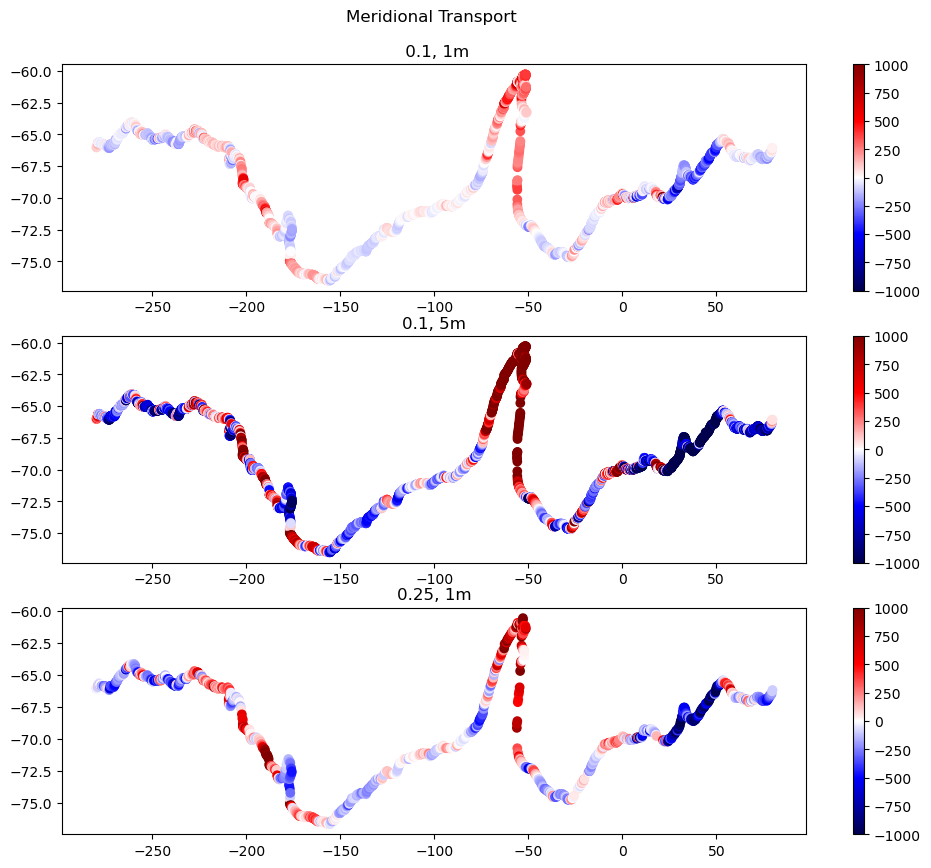

In [33]:
plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
x_ocean_01_v1m = V_transport_1m_NS.sortby('x_ocean').x_ocean
y_ocean_01_v1m = V_transport_1m_NS.sortby('x_ocean').y_ocean
plt.scatter(x_ocean_01_v1m,y_ocean_01_v1m,c = V_transport_1m_NS.sortby('x_ocean').isel(st_ocean=0),vmin=-1000,vmax=1000,cmap='seismic')
plt.colorbar(); plt.title('Meridional Transport \n \n '+'0.1, 1m')


plt.subplot(3,1,2)
x_ocean_01_v5m = V_transport_5m_NS.sortby('x_ocean').x_ocean
y_ocean_01_v5m = V_transport_5m_NS.sortby('x_ocean').y_ocean
plt.scatter(x_ocean_01_v5m,y_ocean_01_v5m,c = V_transport_5m_NS.sortby('x_ocean').isel(st_ocean=0),vmin=-1000,vmax=1000,cmap='seismic')
plt.colorbar(); plt.title('0.1, 5m')


plt.subplot(3,1,3)
x_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').x_ocean
y_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').y_ocean
plt.scatter(x_ocean_025_v1m,y_ocean_025_v1m,c = V_transport_1m_025_NS.sortby('x_ocean').isel(st_ocean=0),vmin=-1000,vmax=1000,cmap='seismic')
plt.colorbar(); plt.title('0.25, 1m')

Text(0.5, 1.0, '0.25, 1m')

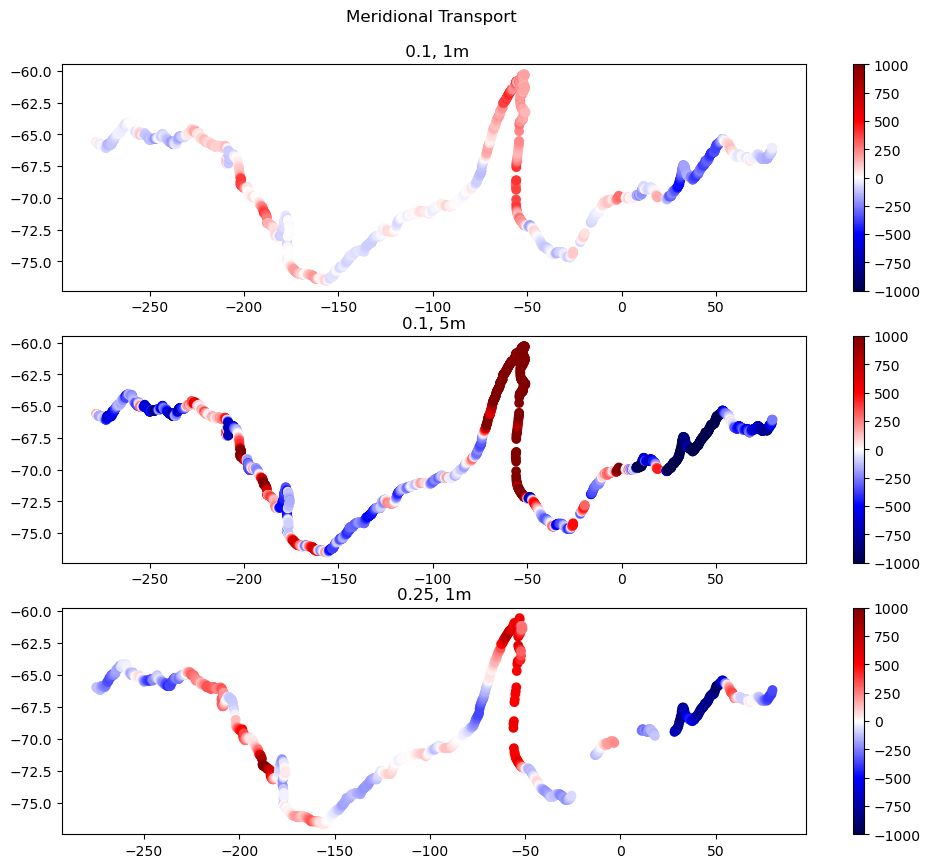

In [34]:
#rolling mean versin
plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
x_ocean_01_v1m = V_transport_1m_NS.sortby('x_ocean').x_ocean
y_ocean_01_v1m = V_transport_1m_NS.sortby('x_ocean').y_ocean
plt.scatter(x_ocean_01_v1m,y_ocean_01_v1m,c = V_transport_1m_NS.sortby('x_ocean').isel(st_ocean=0).rolling(contour_index=20).mean(),vmin=-1000,vmax=1000,cmap='seismic')
plt.colorbar(); plt.title('Meridional Transport \n \n '+'0.1, 1m')


plt.subplot(3,1,2)
x_ocean_01_v5m = V_transport_5m_NS.sortby('x_ocean').x_ocean
y_ocean_01_v5m = V_transport_5m_NS.sortby('x_ocean').y_ocean
plt.scatter(x_ocean_01_v5m,y_ocean_01_v5m,c = V_transport_5m_NS.sortby('x_ocean').isel(st_ocean=0).rolling(contour_index=20).mean(),vmin=-1000,vmax=1000,cmap='seismic')
plt.colorbar(); plt.title('0.1, 5m')


plt.subplot(3,1,3)
x_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').x_ocean
y_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').y_ocean
plt.scatter(x_ocean_025_v1m,y_ocean_025_v1m,c = V_transport_1m_025_NS.sortby('x_ocean').isel(st_ocean=0).rolling(contour_index=20).mean(),vmin=-1000,vmax=1000,cmap='seismic')
plt.colorbar(); plt.title('0.25, 1m')

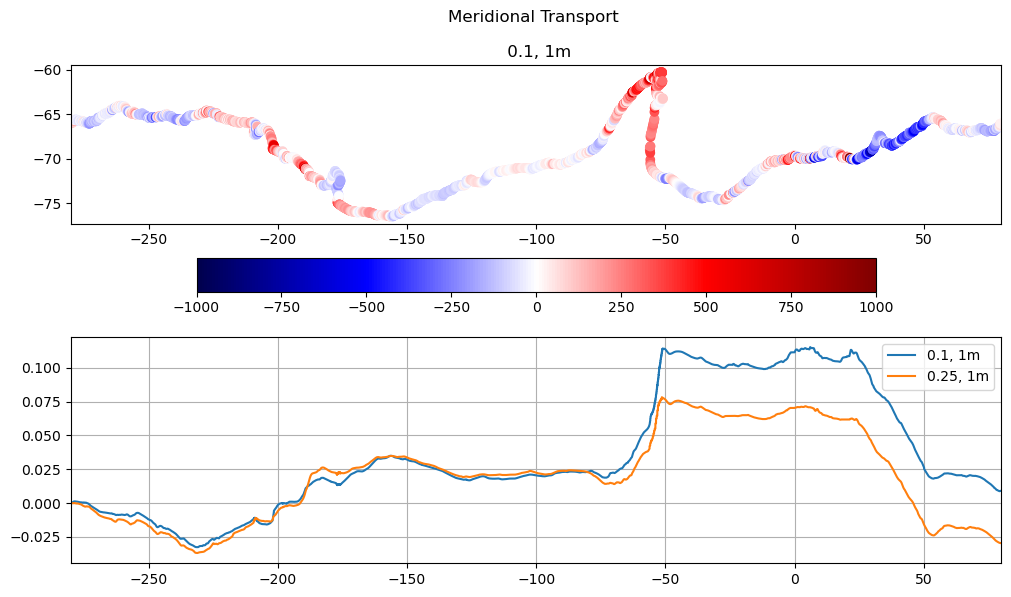

In [35]:
#cumsum
plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
x_ocean_01_v1m = V_transport_1m_NS.sortby('x_ocean').x_ocean
y_ocean_01_v1m = V_transport_1m_NS.sortby('x_ocean').y_ocean
plt.scatter(x_ocean_01_v1m,y_ocean_01_v1m,c = V_transport_1m_NS.sortby('x_ocean').isel(st_ocean=0),vmin=-1000,vmax=1000,cmap='seismic')
plt.colorbar(orientation='horizontal'); plt.title('Meridional Transport \n \n '+'0.1, 1m')
plt.xlim(-280,80)

x_ocean_01_v5m = V_transport_5m_NS.sortby('x_ocean').x_ocean
y_ocean_01_v5m = V_transport_5m_NS.sortby('x_ocean').y_ocean
x_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').x_ocean
y_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').y_ocean
x_ocean_025_v5m = V_transport_5m_025_NS.sortby('x_ocean').x_ocean
y_ocean_025_v5m = V_transport_5m_025_NS.sortby('x_ocean').y_ocean

plt.subplot(3,1,2)
plt.plot(x_ocean_01_v1m,V_transport_1m_NS.sortby('x_ocean').isel(st_ocean=0).cumsum('contour_index')/1e6,label='0.1, 1m')
#plt.plot(x_ocean_01_v5m,V_transport_5m_NS.sortby('x_ocean').isel(st_ocean=0).cumsum('contour_index')/1e6,label='0.1, 5m')
plt.plot(x_ocean_025_v1m ,V_transport_1m_025_NS.sortby('x_ocean').isel(st_ocean=0).cumsum('contour_index')/1e6,label='0.25, 1m')
# plt.plot(x_ocean_025_v5m ,V_transport_5m_025_NS.sortby('x_ocean').isel(st_ocean=0).cumsum('contour_index')/1e6,label='0.25, 5m')
plt.legend()
plt.xlim(-280,80)
plt.grid()


It might be worth to do another simulation with stronger meiridonal winds, to see if we can have a northward mass transport

(-280.0, 80.0)

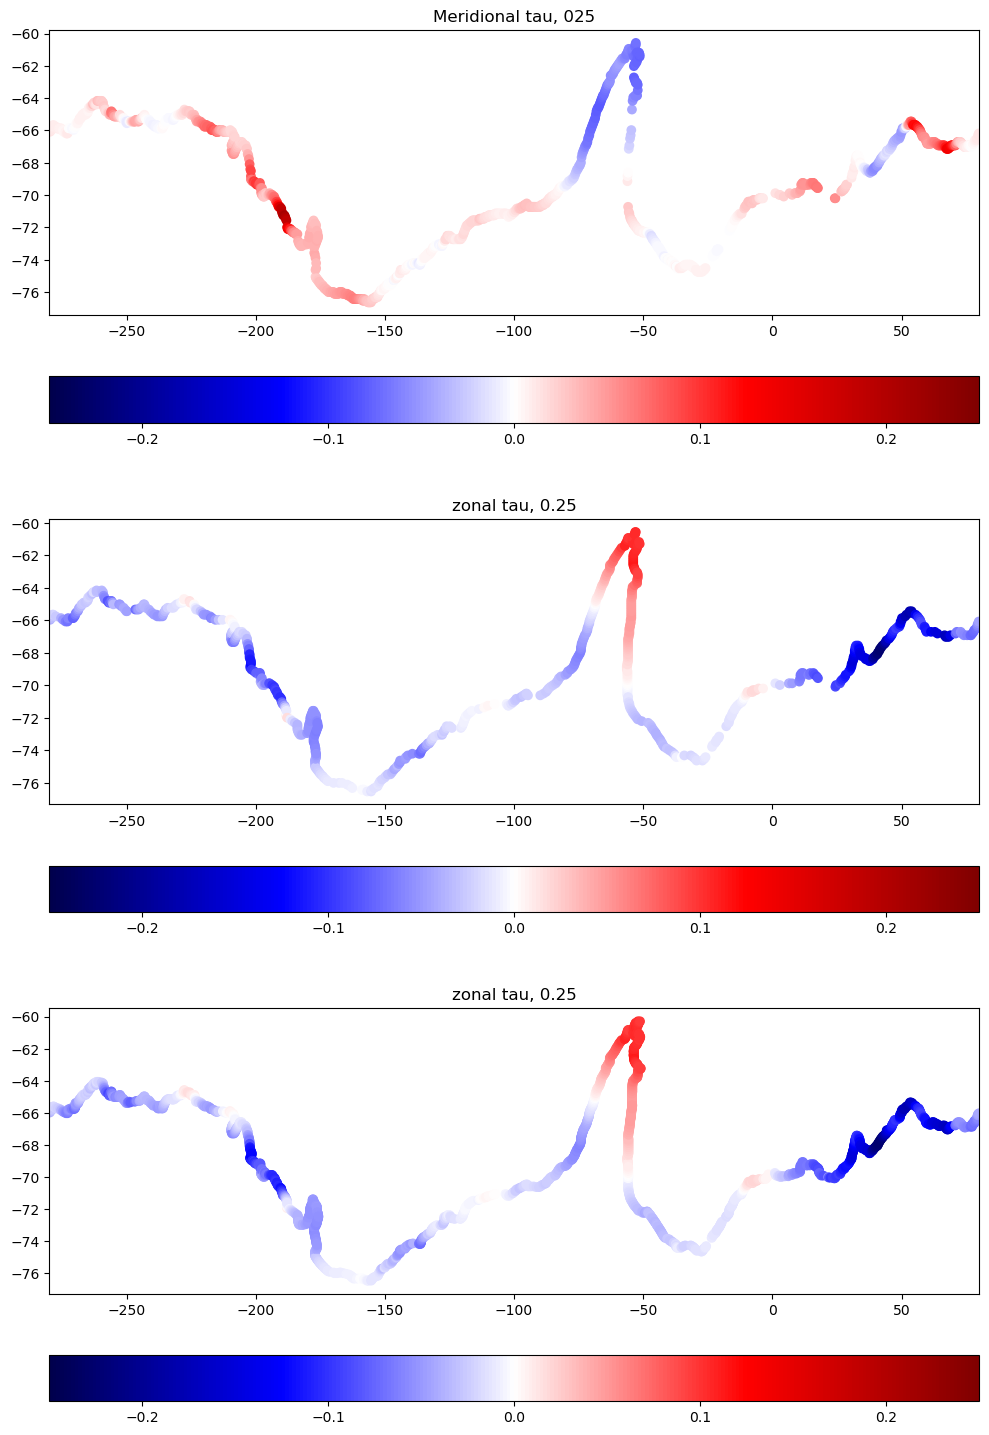

In [36]:
plt.figure(figsize=(12,18))


x_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').x_ocean
y_ocean_025_v1m = V_transport_1m_025_NS.sortby('x_ocean').y_ocean
xX_ocean_025_v1m = U_transport_1m_025_NS.sortby('x_ocean').x_ocean
yX_ocean_025_v1m = U_transport_1m_025_NS.sortby('x_ocean').y_ocean
xX_ocean_01_v5m = U_transport_5m_NS.sortby('x_ocean').x_ocean
yX_ocean_01_v5m = U_transport_5m_NS.sortby('x_ocean').y_ocean

plt.subplot(3,1,1)
plt.scatter(x_ocean_025_v1m,y_ocean_025_v1m,c = y_transport_1m_025.sortby('x_ocean'),vmin=-.25,vmax=.25,cmap='seismic')
plt.colorbar(orientation='horizontal'); plt.title('Meridional tau, 025')
plt.xlim(-280,80)


plt.subplot(3,1,2)
plt.scatter(xX_ocean_025_v1m,yX_ocean_025_v1m,c = x_transport_1m_025.sortby('x_ocean'),vmin=-.25,vmax=.25,cmap='seismic')
plt.colorbar(orientation='horizontal'); plt.title('zonal tau, 0.25')
plt.xlim(-280,80)


plt.subplot(3,1,3)
plt.scatter(xX_ocean_01_v5m,yX_ocean_01_v5m,c = x_transport_1m.sortby('x_ocean'),vmin=-.25,vmax=.25,cmap='seismic')
plt.colorbar(orientation='horizontal'); plt.title('zonal tau, 0.25')
plt.xlim(-280,80)


## Part 2 - Surface water mass transformation and overflow response

Let's check the SWMT then. how different they are in the first 3 years between the 2 vertical and horizontal resolutions

In [136]:
#DSW definitions
σ0_DSW_1m_mindens = 27.85499999999
σ0_DSW_1m_maxdens = 27.95000000
σ0_ref = np.round(σ0_DSW_1m_mindens,2)
σ0_ref

27.85

#### Importing OM2-0.1

In [137]:
import glob

In [138]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/01deg_jra55v13_ryf9091_21mbath/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
c21mbath=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [139]:
gl =sorted(glob.glob("/home/156/wf4500/v45_wf4500/DSW_collaborative/sigma0_SWMT/ryf_5mtoponly/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
r5mtop=xr.open_mfdataset(gl, concat_dim='time',combine='nested')


10 netcdf data files


In [140]:
#for time reference
Overflow_P1mtop= xr.open_mfdataset('/g/data/e14/cs6673/mom6_comparison/data_DSW/vol_transp_across_1000m_isobath_panan_01deg_jra55_ryf_1m_*')


In [141]:
basedir='/home/156/wf4500/v45_wf4500/DSW_collaborative/Daily_mass_transports'

#OM2_21mbath (1mtop
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_21mbath_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

#OM2_5mtop (5mtop)
gl =sorted(glob.glob(basedir + "/01deg_jra55v13_ryf9091_21mbath_5mtop/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:120]
OM2_5mtop_voltrans=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
I

In [142]:
# The sum of overflow will be
Overflowsum_OM5mtop=OM2_5mtop_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OM1mtop=OM2_21mbath_voltrans.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))


In [143]:
OM1rho = np.tile(Overflowsum_OM1mtop.isopycnal_bins,[10,1])
OM5rho = np.tile(Overflowsum_OM5mtop.isopycnal_bins,[10,1])

In [144]:
def shelf_mask_isobath_01(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map  = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map  = xr.DataArray(shelf_map,  coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask

    return masked_var, shelf_map

In [145]:
################# 01, first 3 years ####################################
age_OM2_1m = cc.querying.getvar('01deg_jra55v13_ryf9091_21mbath', 'age_global', cosima_session,\
                               frequency='1 monthly',chunks={"time":  '200MB'})\
.isel(time=slice(96-12,96)).sel(yt_ocean=slice(-90,-50)).mean('time')


# Separating the age at the bottom 
depth_array_1m = age_OM2_1m * 0 + age_OM2_1m.st_ocean
max_depth = depth_array_1m.max(dim = 'st_ocean', skipna= True)
ageob_OM2_1m = age_OM2_1m.where(depth_array_1m.st_ocean >= max_depth)
ageob_OM2_1m = ageob_OM2_1m.sum(dim = 'st_ocean')
ageob_OM2_1m

ageob_OM2_1m.load()
ageob_OM2_1m_offshelf = ageob_OM2_1m.where(shelf_mask<1)

#### Importing OM2-0.25

In [146]:
gl =sorted(glob.glob("/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/025deg_jra55_ryf/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
c21mbath_025=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

8 netcdf data files


In [147]:
gl =sorted(glob.glob("/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/025deg_jra55_ryf_5mtop/yr*/SWMT_*.nc"))
print("%i netcdf data files"%len(gl))
#importing data from ocean.nc
r5mtop_025=xr.open_mfdataset(gl, concat_dim='time',combine='nested')

8 netcdf data files


In [148]:
basedir_025='/g/data/ik11/users/wf4500/DSW_collaborative/Daily_mass_transports'

#OM2_21mbath (1mtop
gl =sorted(glob.glob(basedir_025 + "/025deg_jra55_ryf/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:102]
OM2_21mbath_voltrans_025=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

#OM2_5mtop (5mtop)
gl =sorted(glob.glob(basedir_025 + "/025deg_jra55_ryf_5mtop/Antarctic_cross_slope/*.nc"))
expt0_voltrans=xr.open_mfdataset(gl, concat_dim='time',combine='nested')
expt0_voltrans['time']=Overflow_P1mtop.time[:107]
OM2_5mtop_voltrans_025=expt0_voltrans.groupby('time.year').mean('time')
del expt0_voltrans

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
I

In [149]:
# The sum of overflow will be
Overflowsum_OM5mtop_025=OM2_5mtop_voltrans_025.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))
Overflowsum_OM1mtop_025=OM2_21mbath_voltrans_025.sum('contour_index').isel(isopycnal_bins=slice(None, None, -1))


In [150]:
OM1rho_025 = np.tile(Overflowsum_OM1mtop_025.isopycnal_bins,[10,1])
OM5rho_025 = np.tile(Overflowsum_OM5mtop_025.isopycnal_bins,[10,1])

In [151]:
contour_025 = xr.open_dataset('/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/OM2_025_1000m_isobath_contour.nc')
shelf_mask_025 = contour_025.shelf_mask.rename({'ym_ocean':'yt_ocean','xm_ocean':'xt_ocean'})

In [152]:
def shelf_mask_isobath_025(var,shelf_mask):
    masked_var = var * shelf_mask
    return masked_var

In [153]:
################# 01, first 3 years ####################################
age_OM2_1m_025 = cc.querying.getvar(exp_025_1m, 'age_global', OM025_session, \
                               frequency='1 monthly',chunks={"time":  '200MB'})\
.isel(time=slice(96-12,96)).sel(yt_ocean=slice(-90,-50)).mean('time')


# Separating the age at the bottom 
depth_array_1m_025 = age_OM2_1m_025 * 0 + age_OM2_1m_025.st_ocean
max_depth_025 = depth_array_1m_025.max(dim = 'st_ocean', skipna= True)
ageob_OM2_1m_025 = age_OM2_1m_025.where(depth_array_1m_025.st_ocean >= max_depth_025)
ageob_OM2_1m_025 = ageob_OM2_1m_025.sum(dim = 'st_ocean')


ageob_OM2_1m_025.load()
offshelf_mask_025 = shelf_mask_025.fillna(2)
offshelf_mask_025 = (offshelf_mask_025.where(offshelf_mask_025>1.5)*0)+1
ageob_OM2_1m_offshelf_025 = ageob_OM2_1m_025* offshelf_mask_025

#### separating the transformation rates on the shelf (in Sv)

In [154]:
#importing area in OM2-01
area_t01 = cc.querying.getvar('01deg_jra55v13_ryf9091', 'area_t', cosima_session, n=1) # needed for the plots I'll provide.
area_t025 = cc.querying.getvar(exp_025_1m, 'area_t', OM025_session, n=1) # needed for the plots I'll provide.


getting the SWMT in the shelf of OM2-01

In [155]:
#masking outside the shelf
swmt21mbath_shelf, shelf_mask = shelf_mask_isobath_01(c21mbath.surface_water_mass_transformation)
swmt5mtop_shelf, shelf_mask = shelf_mask_isobath_01(r5mtop.surface_water_mass_transformation)
areat_shelf01, shelf_mask = shelf_mask_isobath_01(area_t01)

#multiplying SWMT by area to get m3/s
swmt21mbath_sum = (swmt21mbath_shelf * area_t01 / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmt5mtop_sum = (swmt5mtop_shelf * area_t01 / 1e6).sum(['xt_ocean', 'yt_ocean']).load()

In [156]:
#OM2_01 DSW formation rates
swmt21mbath_sum_DSW =  swmt21mbath_sum.where(swmt21mbath_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt21mbath_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)


# #and for OM2, 5m case ##################################
swmt5mtop_sum_DSW =  swmt5mtop_sum.where(swmt5mtop_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt5mtop_sum.isopycnal_bins<=σ0_DSW_1m_maxdens)

In [157]:
#masking off shelf
swmt21mbath_shelf_025 = shelf_mask_isobath_025(c21mbath_025.surface_water_mass_transformation, shelf_mask_025)
swmt5mtop_shelf_025 = shelf_mask_isobath_025(r5mtop_025.surface_water_mass_transformation, shelf_mask_025)
areat_shelf025 = shelf_mask_isobath_025(area_t025, shelf_mask_025)

#multiplying SWMT by area to get m3/s
swmt21mbath_sum_025 = (swmt21mbath_shelf_025 * area_t025 / 1e6).sum(['xt_ocean', 'yt_ocean']).load()
swmt5mtop_sum_025 = (swmt5mtop_shelf_025 * area_t025 / 1e6).sum(['xt_ocean', 'yt_ocean']).load()




In [158]:
#OM2_01 DSW formation rates
swmt21mbath_sum_025_DSW =  swmt21mbath_sum_025.where(swmt21mbath_sum_025.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt21mbath_sum_025.isopycnal_bins<=σ0_DSW_1m_maxdens)


# #and for OM2, 5m case ##################################
swmt5mtop_sum_025_DSW =  swmt5mtop_sum_025.where(swmt5mtop_sum.isopycnal_bins>=σ0_DSW_1m_mindens).\
where(swmt5mtop_sum_025.isopycnal_bins<=σ0_DSW_1m_maxdens)

In [159]:
#index for years in analysis
yearind=slice(0,8)

In [160]:
%%time
### creating spatial plot data for OM01
area_t01_forswmt = area_t01.isel(yt_ocean=slice(0,510))
area_t01_forswmt.load()

CPU times: user 117 ms, sys: 49.4 ms, total: 167 ms
Wall time: 220 ms


<xarray.DataArray 'area_t' (yt_ocean: 510, xt_ocean: 3600)> Size: 7MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [32539520., 32539520., 32539520., ..., 32539520., 32539520.,
        32539520.],
       [32637138., 32637138., 32637138., ..., 32637138., 32637138.,
        32637138.],
       [32734998., 32734998., 32734998., ..., 32734998., 32734998.,
        32734998.]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    geolon_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... 79.75 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 7MB nan nan nan ... -59.03 -59.03
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [161]:
SWMT_21mbath_in = swmt21mbath_shelf.isel(time=yearind)
SWMT_21mbath_in['time'] = swmt5mtop_sum_025.time
SWMT_21mbath_in = SWMT_21mbath_in.mean('time')
SWMT_21mbath_in
SWMT_21mbath_in.load()

<xarray.DataArray (isopycnal_bins: 249, yt_ocean: 510, xt_ocean: 3600)> Size: 4GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * yt_ocean        (yt_ocean) float64 4kB -81.11 -81.07 ... -59.08 -59.03
  * xt_ocean        (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * isopycnal_bins  (isopycnal_bins) float64 2kB 24.01 24.03 ... 28.95 28.97

In [162]:
swmt21mbath_shelf_spatialplot=(SWMT_21mbath_in * area_t01_forswmt) #m3/s

In [163]:
### creating spatial plot data for OM025
area_t025_forswmt = area_t025.isel(yt_ocean=slice(0,204))
swmt21mbath_shelf_spatialplot_025=(swmt21mbath_shelf_025.isel(time=yearind).mean('time') * area_t025_forswmt).load() #m3/s


In [164]:
figpath='/g/data/ik11/users/wf4500/DSW_collaborative/sigma0_SWMT/figs/'

  result = super().contourf(*args, **kwargs)

  result = super().contour(*args, **kwargs)

  result = super().contourf(*args, **kwargs)

  result = super().contour(*args, **kwargs)



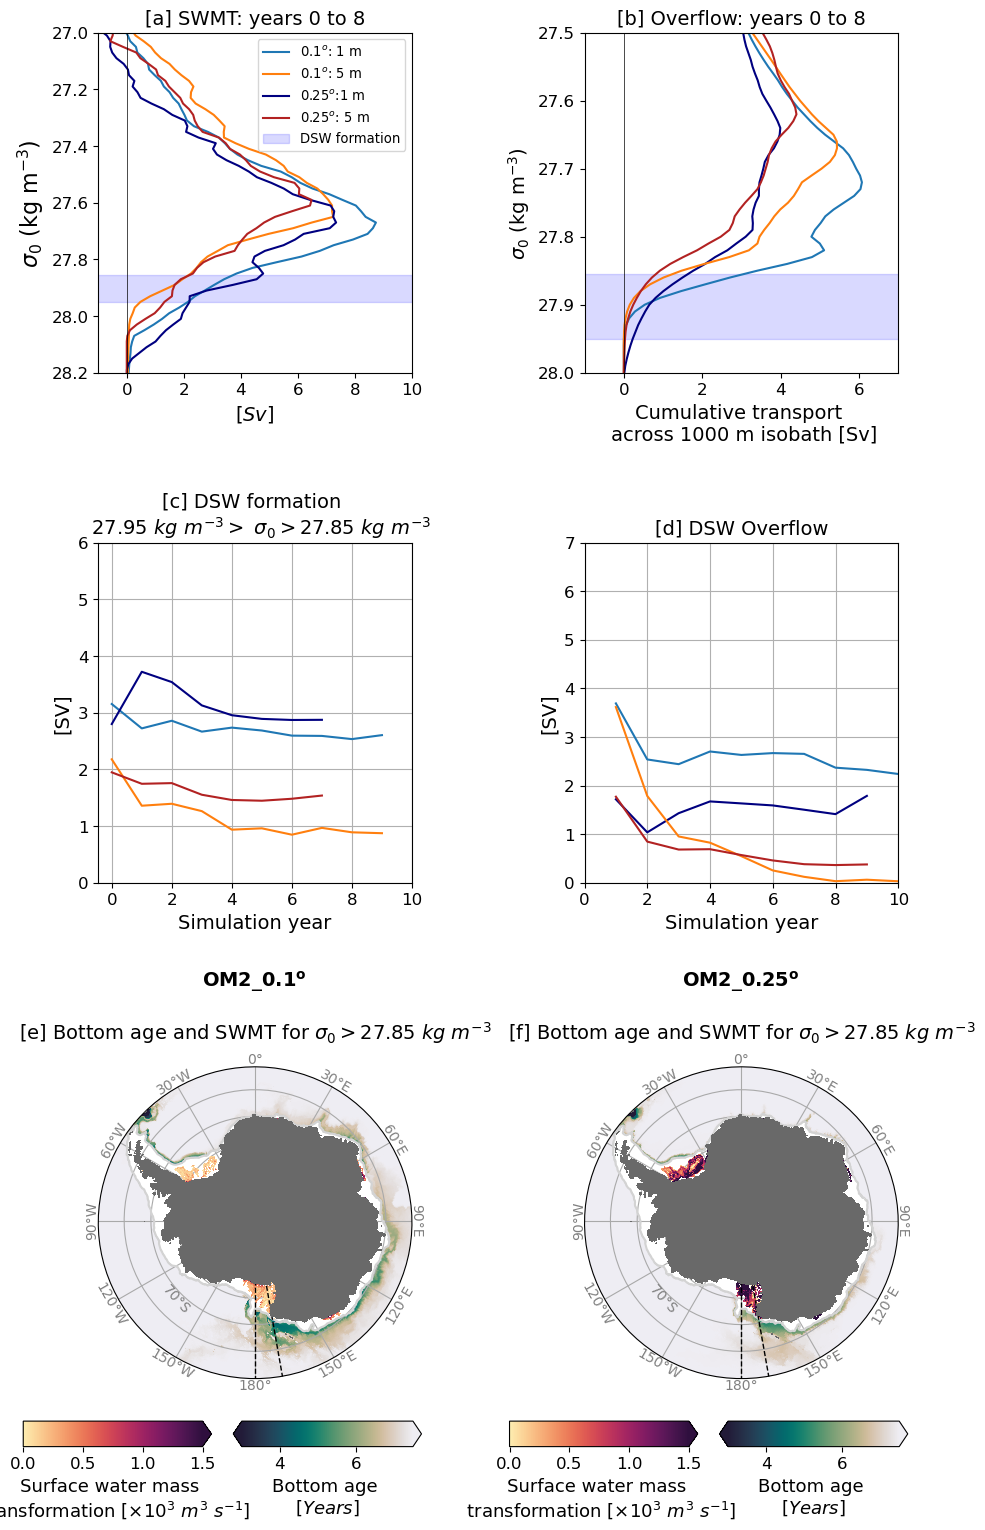

In [165]:
figure = plt.figure(num=1, figsize = (10,17))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.55, 
                    hspace=0.5)

SWMT_contour_color = 'indigo'
SWMT_contour_thickness = 1.6
agemax =7.5
agemin =3

#DSW definition polygon for MOM5
MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15, label='DSW formation')


### SWMT curves
ax_421 = plt.subplot(3,2,1)
plt.plot(swmt21mbath_sum.isel(time=yearind).mean('time'), swmt21mbath_sum.isopycnal_bins, color='tab:blue',label=r'$0.1^o$: 1 m')
plt.plot(swmt5mtop_sum.isel(time=yearind).mean('time'), swmt5mtop_sum.isopycnal_bins, color='tab:orange',label=r'$0.1^o$: 5 m')
plt.plot(swmt21mbath_sum_025.isel(time=yearind).mean('time'), swmt21mbath_sum_025.isopycnal_bins, color='navy',label=r'$0.25^o$:1 m')
plt.plot(swmt5mtop_sum_025.isel(time=yearind).mean('time'), swmt5mtop_sum_025.isopycnal_bins, color='firebrick',label=r'$0.25^o$: 5 m')
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_421.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,10); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylim((28.2,27)); plt.legend(fontsize=9.5)
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 16)
plt.xlabel( r'[$Sv$]', fontsize=14)
plt.title(r"[a] SWMT: years 0 to 8",fontsize=14)



MOM5_σ0_poly = Polygon([(-3,σ0_DSW_1m_mindens), (10,σ0_DSW_1m_mindens),(10,σ0_DSW_1m_maxdens), (-3,σ0_DSW_1m_maxdens),(-3,σ0_DSW_1m_mindens)]\
                       ,color='blue',edgecolor=None,alpha=0.15)
ax_423 = plt.subplot(3,2,2)
plt.plot(Overflowsum_OM1mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM1mtop.isopycnal_bins, color='tab:blue')
plt.plot(Overflowsum_OM1mtop_025.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM1mtop_025.isopycnal_bins, color='navy')
plt.plot(Overflowsum_OM5mtop.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM5mtop.isopycnal_bins,color='tab:orange')
plt.plot(Overflowsum_OM5mtop_025.isel(year=yearind).mean('year').vol_trans_across_contour_binned.cumsum('isopycnal_bins')/1e6,\
         Overflowsum_OM5mtop_025.isopycnal_bins,color='firebrick')
plt.plot([0, 0], [29,26], 'k', linewidth=0.5)
ax_423.add_patch(MOM5_σ0_poly)
#plt.plot([-1, 10], [σ0_ref,σ0_ref], 'b', linewidth=0.5,label=r'$\sigma_0 =$'+str(σ0_ref)); 
plt.xlim(-1,7); #plt.legend(fontsize=12)
plt.ylim((28,27.5)); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.ylabel(r'$\sigma_0$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Cumulative transport \n across 1000 m isobath [Sv]', fontsize=14)
plt.title(r"[b] Overflow: years 0 to 8",fontsize=14)





#SWMT timeseries
plt.subplot(3,2,3)
#SWMT:
(swmt21mbath_sum_DSW.mean('isopycnal_bins')\
).plot(color='tab:blue')
(swmt21mbath_sum_025_DSW.mean('isopycnal_bins')\
).plot(color='navy')
(swmt5mtop_sum_DSW.mean('isopycnal_bins')\
).plot(color='tab:orange')
(swmt5mtop_sum_025_DSW.mean('isopycnal_bins')\
).plot(color='firebrick')
plt.ylim(0,6)
#plt.legend(fontsize=10); 
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.grid(); plt.xticks(ticks=[0,2,4,6,8,10], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14)
plt.title("[c] DSW formation \n " + r' $27.95\ kg \ m^{-3} >$ $\sigma_0 >$' + str(σ0_ref) + r' $kg \ m^{-3}$',fontsize=14)
plt.xlabel('Simulation year', fontsize=14)

#overflow series
plt.subplot(3,2,4)
(Overflowsum_OM1mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OM1mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:blue',label='MOM5_1m')

(Overflowsum_OM1mtop_025.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OM1mtop_025.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='navy',label='MOM5_1m')

(Overflowsum_OM5mtop.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OM5mtop.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='tab:orange',label='MOM5_5m')

(Overflowsum_OM5mtop_025.vol_trans_across_contour_binned.cumsum('isopycnal_bins').\
 where(Overflowsum_OM5mtop_025.isopycnal_bins>σ0_DSW_1m_mindens).max('isopycnal_bins')/1e6)\
.plot(color='firebrick',label='MOM5_5m')

plt.xlim(1990.5,2000); plt.ylim(0,7)
plt.grid(); plt.xticks(ticks=[1990,1992,1994,1996,1998,2000], labels=['0','2','4','6','8','10'])
plt.ylabel('[SV]', fontsize=14); plt.xticks(fontsize=12); plt.yticks(fontsize=12);
plt.title("[d] DSW Overflow",fontsize=14)
plt.xlabel('Simulation year', fontsize=14)





#DSW formation sites on OM2-01

#maps with SWMT + ageOB ( Gee!)
proj = ccrs.PlateCarree()
ax325 = plt.subplot(3,2,5, projection=ccrs.SouthPolarStereo())
ax325.set_extent([-180, 180, -90, -60], proj)
ax325.set_boundary(circle, transform=ax325.transAxes)

gl = ax325.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5] 
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax325.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax325.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)


plt.plot([-180,-180],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)
plt.plot([-190,-190],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)

ax325.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)



plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj,)



p325 = ax325.pcolormesh(swmt21mbath_shelf_spatialplot.xt_ocean, swmt21mbath_shelf_spatialplot.yt_ocean,
                   swmt21mbath_shelf_spatialplot.sel(isopycnal_bins=σ0_ref,method='nearest')/1e3,\
                        vmin=0, vmax=1.5,
                   cmap=cmo.matter, transform=proj,
                   rasterized=True, zorder=3)







pos = ax325.get_position()
cax = plt.axes([pos.xmin-.075, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])


cb325 = plt.colorbar(p325, orientation='horizontal', cax=cax, extend='max')
cb325.ax.tick_params(labelsize=12)
cb325.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)


p325_1 = ax325.pcolormesh(ageob_OM2_1m_offshelf.xt_ocean, ageob_OM2_1m_offshelf.yt_ocean,
                   ageob_OM2_1m_offshelf,\
                        vmin=agemin, vmax=agemax,
                   cmap=cmo.rain_r, transform=proj,
                   rasterized=True, zorder=0)

cax_0T = plt.axes([pos.xmin+0.135, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])
cb325_1 = plt.colorbar(p325_1, orientation='horizontal', cax=cax_0T, extend='both')
cb325_1.ax.tick_params(labelsize=12)
cb325_1.ax.set_xlabel('Bottom age \n' +
                 r'[$Years$]',fontsize=13)
ax325.set_title(r'$\bf{OM2}$_$\bf{0.1^o}$' \
          +' \n \n'+'[e] Bottom age and SWMT for ' +  r'$\sigma_0>$' + str(σ0_ref) + ' $kg\ m^{-3}$', pad=20, fontsize=14)








#DSW formation sites on OM2-025
proj = ccrs.PlateCarree()
ax326 = plt.subplot(3,2,6, projection=ccrs.SouthPolarStereo())
ax326.set_extent([-180, 180, -90, -60], proj)
ax326.set_boundary(circle, transform=ax326.transAxes)

gl = ax326.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5] 
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax326.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax326.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)


plt.plot([-180,-180],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)
plt.plot([-190,-190],[-90,-50],
             color = 'black', linestyle = '--', linewidth=1,
            transform=proj, zorder=4)

ax326.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='dimgray', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=6)



plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj,)



p326 = ax326.pcolormesh(swmt21mbath_shelf_spatialplot_025.xt_ocean, swmt21mbath_shelf_spatialplot_025.yt_ocean,
                   swmt21mbath_shelf_spatialplot_025.sel(isopycnal_bins=σ0_ref,method='nearest')/1e3,\
                        vmin=0, vmax=1.5,
                   cmap=cmo.matter, transform=proj,
                   rasterized=True, zorder=3)







pos = ax326.get_position()
cax = plt.axes([pos.xmin-.075, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])


cb326 = plt.colorbar(p326, orientation='horizontal', cax=cax, extend='max')
cb326.ax.tick_params(labelsize=12)
cb326.ax.set_xlabel('Surface water mass \n transformation ' +
                 r'[$\times 10^{3}\ m^{3}\ s^{-1}$]',fontsize=13)


p326_1 = ax326.pcolormesh(ageob_OM2_1m_offshelf_025.xt_ocean, ageob_OM2_1m_offshelf_025.yt_ocean,
                   ageob_OM2_1m_offshelf_025,\
                        vmin=agemin, vmax=agemax,
                   cmap=cmo.rain_r, transform=proj,
                   rasterized=True, zorder=0)

cax_0T = plt.axes([pos.xmin+0.135, pos.ymin-0.04,
                .6*(pos.xmax-pos.xmin), 0.015])
cb326_1 = plt.colorbar(p326_1, orientation='horizontal', cax=cax_0T, extend='both')
cb326_1.ax.tick_params(labelsize=12)
cb326_1.ax.set_xlabel('Bottom age \n' +
                 r'[$Years$]',fontsize=13)
ax326.set_title(r'$\bf{OM2}$_$\bf{0.25^o}$' \
          +' \n \n'+'[f] Bottom age and SWMT for ' +  r'$\sigma_0>$' + str(σ0_ref) + ' $kg\ m^{-3}$', pad=20, fontsize=14)



plt.savefig(figpath+'Rv0_Figure_CM.png',dpi=300,bbox_inches='tight')
plt.savefig(figpath+'Rv0_Figure_CM.pdf',dpi=300,bbox_inches='tight')
